Start by importing all the modules you will need

In [41]:
import tensorflow as tf

%matplotlib inline 
# Above line Needed for juypter only
from matplotlib import pyplot as plt
import pandas as pd

print("Tensorflow version : ", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU visible",end=" ")
    if tf.test.is_built_with_cuda():
        print("-> GPU enabled")
else:
    print("GPU not visible")

Tensorflow version :  2.13.1
GPU not visible


# Keras and Tensorflow

Keras is a high level API for machine learning, Tensorflow is built on top of keras so it can be used more easily in python

GPU is not supported as of Tensorflow 2.10 for windows

Tensorflow site:

https://www.tensorflow.org/

This notebook follows the beginner quickstart guide

https://www.tensorflow.org/tutorials/quickstart/beginner



# Data

The data we will be using is a series of hand drawn images of numbers 0 to 9, Each image is labeled with its correct answer so that the model can improve its results. Tensorflow/keras comes with this dataset and other datasets already but you can get it from the site too. Other data sets are available such as items of clothing.

http://yann.lecun.com/exdb/mnist/

We will be training the model using "supervised learning" this is where we provide labels with the image.

[IBM : supervised learning](https://www.ibm.com/topics/supervised-learning#:~:text=Supervised%20learning%2C%20also%20known%20as,data%20or%20predict%20outcomes%20accurately.)

We seperate out two sets of data for neural networks, this seperation should be random to avoid bias
- Training data
    - this is the larger set and the model weights will be trained using this
- Testing data
    - we use a test dataset to see how it performs with new data and to compare to previous versions of itself. This is how we can be certain that the model is learning and not memorising.

When training the model we give it the image in the form of a matrix and it has to guess what that image represents, it makes this guess using the output layer, the output is in the form of a probability or confidence, we consider the highest value in the final layer as it's answer in most cases.

A data is often the limiting factor of machine learning models, it needs to be very large, varied and accurately labeled to train a good model. If there is too little data or the data does not have enough variation the model wont be able to find patterns in the dataset to catagorise.

In [42]:
mnist_data = tf.keras.datasets.mnist
(train_images, train_label), (test_images, test_label) = mnist_data.load_data()
# Scale the intergers to values between 0 and 1, this helps remove any biases.
# E.g. 5 is drawn with only values of 255 but 9 is drawn with only values of 1, the model may pick up on this and base its decision entirely on the value of pixels without taking into account other factors
train_images = train_images / 255  # 255 as it is the largest value a pixel can take
test_images = test_images / 255
# (train_images, train_label) = (train_images[:100], train_label[:100]) # A Lower training sample with the same epochs leads to overfitting and it will not be accurately determine the test data
# overfitting should be avoided at all costs

print("Training data size : ", f"{train_label.shape[0]:,}")
print("Test data size     : ", f"{test_label.shape[0]:,}")

Training data size :  60,000
Test data size     :  10,000


The data is a 28x28 matrix with numbers now ranging from 0 to 1. We can plot each point on a graph as a (very large) pixel to represent what the network sees.

Image label : 5


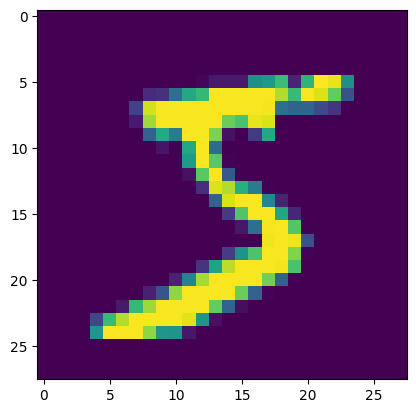

In [43]:
sample_image_index = 0

plt.imshow(train_images[sample_image_index])
# use cmap to change the colour scheme, but keep in mind that the model has no perception of colour, only the value of each pixel in the grid.
print("Image label :", train_label[sample_image_index])

---

# Neural Networks

<div>
<img src="Neural_network_example.svg" width="1000"/>
</div>

Neural networks generate their answers by passing the data through its layers. Each node detects certain pattens which are then used in the next layer or to determine a final output 

Input Layer
---

The Input layer is the first layer of a network and is where the data starts, in the image example above it splits the image between the nodes A and B. For the network we will actually build there will be a node for each pixel.

Hidden Layers
---

The nodes in the hidden layer work to try and identify certain factors about an image, such as the edges, in specific areas. The nodes take the sum of all inputs multiplied by the respective weight. In the image above, Node $C$ takes the input from $A$ and multiplies by $\text{weight}_1$ ($w_1$) then adds the product of $B$ and $\text{weight}_3$ ($w_3$) to get:

$$
(A \cdot \text{weight}_1) + (B \cdot \text{weight}_3)
$$

However this alone is not enough and a bias ($b_1 , b_2$) must be introduced. The purpose of a bias is so that neurons are not always active when only a few of the pixels are present. A bias may sometimes be referred to as a threshold. A bias can also be positive or negative and is automatically adjusted.

The sum of $(A \cdot w_1)$ and $(B \cdot w_2)$ must be greater than or less than $b_1$ for $C$ to emit an output value. Adding the bias to the above calculation gives the equation: 

$$
(A \cdot \text{weight}_1) + (B \cdot \text{weight}_3) + b_1 = C_\text{Value}
$$

Finally the output value needs to be scaled between at least 0 and 1. This is so that the output of a single neuron is not overpowering, these are called activation functions, activation functions can come in may different forms but all of them smoothly scale the node value between the activation function's maximum and minimum, by being smooth the function gives a range of values which are nesscary so that the network can have small adjustments made to its variables.

The final output for node $C$, where $f(x)$ is the activation function, is:

$$
\begin{equation}\begin{aligned}
f(C_\text{Value}) &= C_\text{output}\\
f( (A \cdot \text{weight}_1) + (B \cdot \text{weight}_3) + b_1 ) &= C_\text{output}
\end{aligned}\end{equation}
$$

Output layer
---

The output layer is the final layer and we consider these values to be the final answer of the network. We associate each of the nodes with an answer, there is no particular order it has to be in but as long as it stays consitent while training it will work.

We also repeat the calculations from the hidden layers again replacing $A$ and $B$ with the output from the hidden layer, $C$ and $D$ to get the final output, 

For the network example above we take its answer as the highest value. As we are not passing the output to another layer, there is no need for an activation function.

We initialise the model below, the order of the layers matter. You can add more dense layers if you wish or dropouts in any order, however the first and last layers must stay the same.

In [44]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

The model we initialised is a Sequential model, data is passed through each layer at a time.

- tf.keras.layers.Flatten()
    - Input layer, flattens the input matrix to be a list with length 784 (28 * 28)
- tf.keras.layers.Dense(x, activation="relu")
    - This adds a layer of x nodes with an activation function
- tf.keras.layers.Dropout()
    - Randomly turns off nodes which prevents overfitting, it is a fraction of the nodes to turn off (the node turned off is randomly selected but the amount of nodes turned off is not)
- tf.keras.layers.Dense(x)
    - This final layer is the output and should be the same size as the expected outputs

This code takes the sample data point and passes it through the model to predict what it is, the model has been initialised with random weights. Even if it gets it right, the spread of values for its answers shows its not confident in its result, a well trained model will have less of a spread of values.

This also proves that training our model gives better results.

In [45]:
predictions = model.predict(train_images[[sample_image_index]])
# soft max scales the values between 0 and 1 with the constraint that the sum is equal to 1
probablities = tf.nn.softmax(predictions).numpy()
# This gets us the probability/confidence

d = {index : round(confidence,4) for index, confidence in zip(range(10), probablities[0])}
print("Network Answer :", max(d,key=lambda x : d[x]))
print("Actual Answer  :", train_label[sample_image_index])
# Weights are randomly selected so it may get one or two right by pure chance
print("Confidence levels : ")
d

1/1 [==============================] - 0s 37ms/step
Network Answer : 2
Actual Answer  : 5
Confidence levels : 


{0: 0.1228,
 1: 0.0993,
 2: 0.1827,
 3: 0.0683,
 4: 0.081,
 5: 0.1037,
 6: 0.0958,
 7: 0.0458,
 8: 0.1119,
 9: 0.0887}

---

# Loss

Loss and cost in terms of deep learning are synonyms.

By taking in all the answers from the output layer we can determine how close (or how far) from being correct the model is. As we already have the labels we know what the output should be for each image. When we input an image the output of the network will give us 10 different values, likewise we also know that only one of these should equal 1 so we can compare them. Say we input an image for 1.

$$
\begin{bmatrix} 0.07 \\ 0.12 \\ \cdots \\ 0.19 \\ 0.05 \end{bmatrix} \text{should equal} \begin{bmatrix} 0 \\ 1 \\ \cdots \\ 0 \\ 0 \end{bmatrix}
$$

Using this information we can use the difference of the squares to quantify how wrong it is for a single input:

$$
\text{total loss} = \sum_{i=1}^\text{n}{(X_i - \hat{X}_i)^2}
$$

From the calculated loss we can do a method called back propagation to adjust the weights and biases for a lower loss back propagation is a complex process and will not be covered here. Squaring the errors means all our errors are positive so errors will not cancel out if we wish to take the average and it magnifies the larger errors making them more urgent to fix

This is just one method of calculating the loss. This comes from the mean squared error and is also used in logistic regression, which you will learn in 4IQT.

A lower loss is better and a higher accuracy is better but they are not the direct inverse of each other, this will become evident later with overfitting.

```python

# Sample code of above equation and doesn't work
output_values = model(data)

total_cost = 0

for output in output_values:
    error = output_activation - expected_output
    total_cost += error ** 2

```

We can define the loss function as a variable or model.compile will find it for us if we pass in:
```python
loss="SparseCategoricalCrossentropy"
``` 

In [46]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

---

# Compile, Train and Test 

Finally compile the model to pull everything together.

- The optimizer is an algorithim which determines how to reduce loss. This is also known as Back propagation.

- Metrics is what the optimizer uses to improve weights, accuracy is what you will typically use.

Back propagation is very math heavy and involves multivariable calculus.

More information here : http://neuralnetworksanddeeplearning.com/chap2.html

3Blue1Brown playlist and video : https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2

In [48]:
model.compile(optimizer="adam", loss=loss_function, metrics=["accuracy"])

Now we can train the model using the data, One epoch means the model has seen every image in the training data once. Iterating over epochs improves accuracy.

A Batch is the amount images handed to the model before adjusting its weights. Adjusting weights too soon can be bad should the model recieve multiple of the same in the row. The order of input of training data does effect the neural network.

An epoch too low results in a poor accuracy, but a high epoch will take more time and needs more data to avoid overfitting. Training has a diminishing return on accuracy with the largest jumps of accuracy occuring first then rapidly decreasing after.

In [49]:
history = model.fit(train_images, train_label,epochs=5)
# model.fit returns the history of training over the epochs to save later

Epoch 1/5
1875/1875 [==============================] - 2s 822us/step - loss: 0.4641 - accuracy: 0.8652
Epoch 2/5
1875/1875 [==============================] - 2s 825us/step - loss: 0.2738 - accuracy: 0.9190
Epoch 3/5
1875/1875 [==============================] - 2s 830us/step - loss: 0.2352 - accuracy: 0.9296
Epoch 4/5
1875/1875 [==============================] - 2s 822us/step - loss: 0.2172 - accuracy: 0.9342
Epoch 5/5
1875/1875 [==============================] - 2s 833us/step - loss: 0.2011 - accuracy: 0.9392


Note that in juypter the more times you run the cell above the more accurate it gets, this is becuase model.fit is updating the model object everytime and juypter keeps the model object in memory loaded.

If you want to reset the results then re-run the cell where `model` was initialized.

Finally we evaluate our model with the test data.

In [50]:
test_loss, test_accuracy = model.evaluate(test_images, test_label, verbose=2)
# model.evaluate() returns an array in form [cost, accuracy]

313/313 - 0s - loss: 0.1383 - accuracy: 0.9600 - 275ms/epoch - 879us/step


 The more we train the model the more accurate it becomes against the test set, however there is an upper limit to the model in its current state. To get a higher accuracy on the test data we can:
 - Adjust epochs
 - Adjust nodes
 - Adjust layers
 - Improve training data with more variation or more accurate labels
 - Change batch size
 - Use other activation functions
 - Change dropout rate
 - Use other back propagation functions
 - Use other types of nodes
 - Use Pre-processing

A more complex network will mean it will take longer to train as there is more to calculate, there is no equation for calculating the network size, shape or even optimal amount of epochs for a specific problem so its a matter of trial and error

Also you need to re-train it everytime you adjust it.

---

# Overfitting and model performance

Accuracy increases over epochs, the more it is trained the better it becomes. However the more epochs the model goes over, the more information about the training data is leaked into the model. Over time this causes overfitting, the model begins memorising the data instead of looking for patterns, overfitting occurs sooner for smaller and less varied datasets. 

We can look for overfitting by using the test data and comparing it to the training data, a drop in accuracy and spike in cost generally means it is overfitted. 

- A spike in cost means that it is less confident on its final answers
- A drop in accuracy is because the model has memorised the training data instead of learning patterns, An overfitted model can still be accurate so it is important to use the cost as well

However absolutely no spike also suggests that the model has likely not been trained enough and it can still figure out a lower cost with more epochs.

The speed of a network depends on its size, larger more complex models require more memory, data and calculations.

In the graph below, the final data point is on the test data and this is where the spike should appear. If it doesnt, reduce the sample size and increase the epochs.

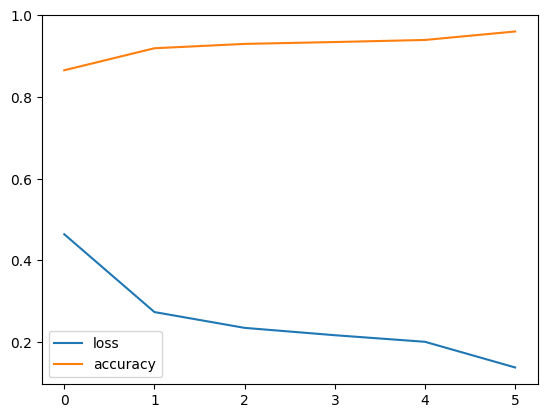

In [51]:
data = pd.DataFrame(history.history)
data.loc[len(data)] = (test_loss, test_accuracy)

plt.plot(data)
plt.legend(data.columns)

Accuracy is measured in % correct 

loss are units which dont represent anything on their own

X axis is the epochs

Using pandas we can save the history directly to csv and we can open it in excel for further analysis

In [52]:
data.to_csv("Training data.csv")

---

# Using the model

Instead of training the model everytime we want to use it, we can save the neural network then load it in later. `model.save(file_path)` saves the entire model, even its structure, so we can load it back in using `tf.keras.models.load_model(file_path)`

Make sure to use the extention .keras

In [53]:
model.save("mynetwork.keras")
model = tf.keras.models.load_model("mynetwork.keras")

To make predictions we use `model.predict()` and pass in a list of the predictions we want it to make.

In [54]:
predictions = model.predict(test_images[[sample_image_index]]) # test_images[[sample_image_index]] as we only want a specific image here, otherwise just pass in a list
# soft max scales the values between 0 and 1 with the constraint that the sum is equal to 1
probablities = tf.nn.softmax(predictions).numpy()
# This gets us the probability/confidence

d = {index : round(confidence,4) for index, confidence in zip(range(10), probablities[0])}
print("Network Answer :", max(d,key=lambda x : d[x]))
print("Actual Answer  :", test_label[sample_image_index])
d

1/1 [==============================] - 0s 38ms/step
Network Answer : 7
Actual Answer  : 7


{0: 0.0,
 1: 0.0,
 2: 1e-04,
 3: 0.0017,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.9982,
 8: 0.0,
 9: 0.0}

---

Now try and modify either the data or neural network to get as high of an accuracy as possible for the testing data. You can compare to the leaderboard found [here](http://yann.lecun.com/exdb/mnist/)

As a challenge automate the network shape iteration and epoch to find the optimal neural network shape and weights.